<a href="https://colab.research.google.com/github/mgnarag/painting_restoration/blob/main/CNN_L_ab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Google drive loading  and function imports

In [1]:
from google.colab import drive
drive.mount("/content/drive")

import os
import contextlib

# Suppress output
with contextlib.redirect_stdout(None):
    os.system('ls drive/My\\ Drive')

file_path = "/content/drive/MyDrive/Baumgartner screenshots/SPIE 2025 new runs/Paintings/"

Mounted at /content/drive


In [2]:
import time
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

from PIL import Image, ImageOps
from PIL import Image, ImageDraw
import PIL
PIL.Image.MAX_IMAGE_PIXELS = 236958876
import cv2
from skimage import color

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from tensorflow import keras

from sklearn.model_selection import train_test_split

# 1. Pre-processing: removing the border and spliting the image into train and test

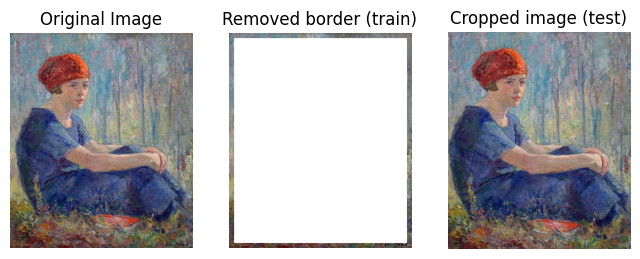

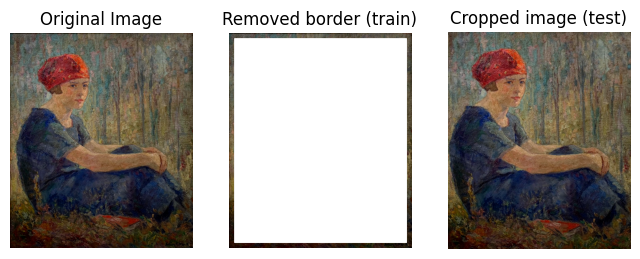

In [3]:
def remove_border(image):
    # Define the crop size
    crop_pixels = 36
    width, height = image.size

    # Create an empty transparent image
    border_only = Image.new("RGBA", (width, height), (255, 255, 255, 0))

    # Paste the original image onto the border_only image
    border_only.paste(image)

    # Now make the center area transparent
    draw = ImageDraw.Draw(border_only)
    draw.rectangle(
        [crop_pixels, crop_pixels, width - crop_pixels, height - crop_pixels],
        fill=(255, 255, 255, 0))

    # Crop the center image (cropped version)
    cropped_image = image.crop((
        crop_pixels,            # left
        crop_pixels,            # top
        width - crop_pixels,     # right
        height - crop_pixels     # bottom
    ))

    # Display the original, cropped, and removed border
    fig, axs = plt.subplots(1, 3, figsize=(8, 4))

    # Original Image
    axs[0].imshow(image)
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    # Removed Border
    axs[1].imshow(border_only)
    axs[1].set_title('Removed border (train)')
    axs[1].axis('off')

    # Cropped Image
    axs[2].imshow(cropped_image)
    axs[2].set_title('Cropped image (test)')
    axs[2].axis('off')

    plt.show()

    cropped_image.save(file_path+"test/"+painting_name+"_test.png")       # Save the cropped center
    border_only.save(file_path+"train/"+painting_name+"_train.png")
    return border_only

 # Load the image
painting_name = '[56-After]'
after_train = remove_border(Image.open(file_path+painting_name+".png"))
painting_name = '[56-Before]'
before_train = remove_border(Image.open(file_path+painting_name+".png"))

# 2. Define relevant functions

In [4]:
def rgb_lab_normalized(im):
    rgb_array = np.array(im) # Convert to numpy array
    rgb_array_normalized = rgb_array / 255.0 # Normalize RGB values from 0 to 1
    lab_array_normalized = color.rgb2lab(rgb_array_normalized) # Convert RGB to LAB colorspace
    lab_array_normalized[..., 0] = (lab_array_normalized[..., 0]) / 100.0 # Scale LAB values to range [0, 1]
    lab_array_normalized[..., 1] = (lab_array_normalized[..., 1] + 128) / 255.0
    lab_array_normalized[..., 2] = (lab_array_normalized[..., 2] + 128) / 255.0
    lab_image_normalized = Image.fromarray((lab_array_normalized * 255).astype(np.uint8), mode='LAB')# Convert LAB array back to image
    return lab_image_normalized

    import tensorflow as tf
from keras.saving import register_keras_serializable

@register_keras_serializable()
def color_loss(y_true, y_pred):
    # Scale from [0,1] to [0,255]
    y_true = y_true * 255.0
    y_pred = y_pred * 255.0

    # Convert RGB to LAB
    y_true_lab = rgb_to_lab(y_true)
    y_pred_lab = rgb_to_lab(y_pred)

    # Separate L, a, b channels
    L1, a1, b1 = tf.split(y_true_lab, 3, axis=-1)
    L2, a2, b2 = tf.split(y_pred_lab, 3, axis=-1)

    # Delta calculations
    delta_L = L1 - L2
    delta_a = a1 - a2
    delta_b = b1 - b2

    delta_e = tf.sqrt(delta_L**2 + delta_a**2 + delta_b**2)

    return tf.reduce_mean(delta_e)

def rgb_to_lab(srgb):
    srgb = tf.clip_by_value(srgb, 0.0, 255.0)
    srgb = srgb / 255.0

    # Convert sRGB to XYZ
    def f(c):
        return tf.where(c > 0.04045, tf.pow((c + 0.055) / 1.055, 2.4), c / 12.92)
    rgb = f(srgb)

    rgb = tf.reshape(rgb, [-1, 3])
    matrix = tf.constant([
        [0.4124564, 0.3575761, 0.1804375],
        [0.2126729, 0.7151522, 0.0721750],
        [0.0193339, 0.1191920, 0.9503041],
    ], dtype=tf.float32)
    xyz = tf.matmul(rgb, matrix)
    xyz = tf.reshape(xyz, tf.shape(srgb))

    # Normalize for D65 white point
    xyz_ref = [0.95047, 1.0, 1.08883]
    xyz = xyz / xyz_ref

    def f_lab(t):
        delta = 6/29
        return tf.where(t > delta**3, tf.pow(t, 1/3), t / (3 * delta**2) + 4/29)

    f_xyz = f_lab(xyz)

    L = 116 * f_xyz[..., 1] - 16
    a = 500 * (f_xyz[..., 0] - f_xyz[..., 1])
    b = 200 * (f_xyz[..., 1] - f_xyz[..., 2])

    lab = tf.stack([L, a, b], axis=-1)
    return lab

# SSIM loss function
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

# 3. Preparing the training dataset: cropping small patches

In [18]:
def crop_patches(image):
  # Parameters
  patch_size = 8
  overlap = 4
  stride = patch_size - overlap  # move 4 pixels at a time

  # Get image size
  width, height = image.size

  # List to collect patch arrays
  patches_array = []

  # Loop over the image
  for y in range(0, height - patch_size + 1, stride):
      for x in range(0, width - patch_size + 1, stride):
          # Crop the patch
          patch = image.crop((x, y, x + patch_size, y + patch_size))

          # Check if the patch is fully opaque
          patch_data = np.array(patch)
          if patch_data.shape[2] == 4:  # RGBA
              alpha_channel = patch_data[:, :, 3]
              if not np.all(alpha_channel == 255):
                  continue  # Skip partially transparent patches

              # Keep only RGB channels (drop alpha)
              patch_rgb = patch_data[:, :, :3]
              patch_lab = rgb_lab_normalized(patch_rgb)
              patches_array.append(patch_lab)
              im1 = np.rot90(patch_lab)
              patches_array.append(im1)
              im1 = np.rot90(im1)
              patches_array.append(im1)

  # Convert list to NumPy array
  patches_array = np.array(patches_array)/255
  return patches_array

input = crop_patches(before_train)
output = crop_patches(after_train)

print("Done reading the input of size = ", input.shape)
print("Done reading the output of size = ", output.shape)

# Split the data into training and testing sets
train_input, test_input, train_output, test_output = train_test_split(
    input, output, test_size=0.2, random_state=42)

print("Done reading the train input of size = ", train_input.shape)
print("Done reading the test input of size = ", test_input.shape)
print("Done reading the train output of size = ", train_input.shape)
print("Done reading the test output of size = ", test_input.shape)

train_input_L = train_input[:,:,:,0:1]
train_input_ab = train_input[:,:,:,1:3]
train_output_L = train_output[:,:,:,0:1]
train_output_ab = train_output[:,:,:,1:3]

test_input_L = test_input[:,:,:,0:1]
test_input_ab = test_input[:,:,:,1:3]
test_output_L = test_output[:,:,:,0:1]
test_output_ab = test_output[:,:,:,1:3]


train_input = []
train_output = []
test_input = []
test_output = []
input = []
output = []

Done reading the input of size =  (29340, 8, 8, 3)
Done reading the output of size =  (29340, 8, 8, 3)
Done reading the train input of size =  (23472, 8, 8, 3)
Done reading the test input of size =  (5868, 8, 8, 3)
Done reading the train output of size =  (23472, 8, 8, 3)
Done reading the test output of size =  (5868, 8, 8, 3)


## Add patches

In [ ]:
from tqdm import tqdm
# Your cropping function
def crop_patches(image):
    patch_size = 8
    overlap = 4
    stride = patch_size - overlap
    width, height = image.size
    patches_array = []

    for y in range(0, height - patch_size + 1, stride):
        for x in range(0, width - patch_size + 1, stride):
            patch = image.crop((x, y, x + patch_size, y + patch_size))
            patch_data = np.array(patch)

            if patch_data.shape[2] == 4:  # RGBA
                alpha_channel = patch_data[:, :, 3]
                if not np.all(alpha_channel == 255):
                    continue
                patch_rgb = patch_data[:, :, :3]
                patch_lab = rgb_lab_normalized(patch_rgb)
                patches_array.append(patch_lab)
                im1 = np.rot90(patch_lab)
                patches_array.append(im1)
                im1 = np.rot90(im1)
                patches_array.append(im1)
    return np.array(patches_array)

# Set directories
before_dir = file_path + 'train/[56-Before]'
after_dir = file_path + 'train/[56-After]'

# Collect matching file names
file_names = sorted([f for f in os.listdir(before_dir) if f.endswith('.png')])

# Lists for all patches
X_train, Y_train = [], []

# Loop through all matching files
for fname in tqdm(file_names, desc="Processing images"):
    before_path = os.path.join(before_dir, fname)
    after_path = os.path.join(after_dir, fname)

    # Load images with alpha
    before_img = Image.open(before_path).convert("RGBA")
    after_img = Image.open(after_path).convert("RGBA")

    # Crop patches
    before_patches = crop_patches(before_img)
    after_patches = crop_patches(after_img)

    # Sanity check: match counts
    n = min(len(before_patches), len(after_patches))
    X_train.append(before_patches[:n])
    Y_train.append(after_patches[:n])

# Stack all patches
X_train = np.vstack(X_train)/255
Y_train = np.vstack(Y_train)/255

print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)

# Make sure train_input and train_output already exist and have matching shapes
train_input = np.concatenate([train_input, X_train], axis=0)
train_output = np.concatenate([train_output, Y_train], axis=0)

print("Updated train_input shape:", train_input.shape)
print("Updated train_output shape:", train_output.shape)


## Visualize the patches

In [ ]:
N = 24000
n = 10
plt.figure(figsize=(10, 4))
for i in range(0,10):
    ax = plt.subplot(2, n, i + 1)
    plt.title("input")
    plt.imshow((train_input[i+N]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    bx = plt.subplot(2, n, i + n + 1)
    plt.title("output")
    plt.imshow((train_output[i+N]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

In [22]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization
from keras.optimizers import Adam
import tensorflow as tf

def unet_model_L(input_shape=(8, 8, 1)):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(8, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(8, 3, activation='relu', padding='same')(conv1)

    #conv2 = Conv2D(16, 3, activation='relu', padding='same', strides=2)(conv1)
    #conv2 = Conv2D(16, 3, activation='relu', padding='same')(conv2)

    # Decoder
    #up1 = Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same')(conv2)
    #concat1 = concatenate([up1, conv1])
    #conv3 = Conv2D(8, 3, activation='relu', padding='same')(concat1)
    #conv3 = Conv2D(8, 3, activation='relu', padding='same')(conv3)

    # Output Layer
    output = Conv2D(1, kernel_size=3, activation='sigmoid', padding='same')(conv1)

    model = Model(inputs=inputs, outputs=output)
    return model

unet_L = unet_model_L()
unet_L.summary()
#---------------------------------------------------
def unet_model_ab(input_shape=(8, 8, 2)):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(8, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(8, 3, activation='relu', padding='same')(conv1)

    #conv2 = Conv2D(16, 3, activation='relu', padding='same', strides=2)(conv1)
    #conv2 = Conv2D(16, 3, activation='relu', padding='same')(conv2)

    # Decoder
    #up1 = Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same')(conv2)
    #concat1 = concatenate([up1, conv1])
    #conv3 = Conv2D(8, 3, activation='relu', padding='same')(concat1)
    #conv3 = Conv2D(8, 3, activation='relu', padding='same')(conv3)

    # Output Layer
    output = Conv2D(2, kernel_size=3, activation='sigmoid', padding='same')(conv1)

    model = Model(inputs=inputs, outputs=output)
    return model

unet_ab = unet_model_ab()
unet_ab.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 8, 8, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 8)        │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 8)        │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 1)        │            73 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 737 (2.88 KB)

 Trainable params: 737 (2.88 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 8, 8, 2)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 8, 8, 8)        │           152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 8, 8, 8)        │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 2)        │           146 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 882 (3.45 KB)

 Trainable params: 882 (3.45 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
from keras.optimizers import Adam
from tensorflow.keras import layers, losses

opt = Adam(learning_rate=0.001)
unet_L.compile(optimizer=opt, loss=losses.MeanSquaredError())
#unet.compile(optimizer=opt, loss=color_loss)
start = time.time()
model = unet_L.fit(train_input_L, train_output_L,
                epochs=100,
                shuffle=True,
                validation_data=(test_input_L, test_output_L),batch_size=32)
end = time.time()

print("The time of execution of above program is :",
      (end-start), "seconds")

unet_L.save(file_path + 'Model/unet_L.keras')

#-----------------------------------------------------
opt = Adam(learning_rate=0.001)
unet_ab.compile(optimizer=opt, loss=losses.MeanSquaredError())
#unet.compile(optimizer=opt, loss=color_loss)
start = time.time()
model = unet_ab.fit(train_input_ab, train_output_ab,
                epochs=100,
                shuffle=True,
                validation_data=(test_input_ab, test_output_ab),batch_size=32)
end = time.time()

print("The time of execution of above program is :",
      (end-start), "seconds")

unet_ab.save(file_path + 'Model/unet_ab.keras')

Epoch 1/100
734/734 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0045 - val_loss: 0.0045
Epoch 2/100
734/734 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0044 - val_loss: 0.0045
Epoch 3/100
734/734 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0044 - val_loss: 0.0045
Epoch 4/100
734/734 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.0044 - val_loss: 0.0045
Epoch 5/100
734/734 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0044 - val_loss: 0.0045
Epoch 6/100
734/734 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0045 - val_loss: 0.0045
Epoch 7/100
734/734 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0045 - val_loss: 0.0045
Epoch 8/100
734/734 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0044 - val_loss: 0.0045
Epoch 9/100
734/734 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0044 - val_loss: 0.0045
Epoch 10/100
734/734 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0044 - val_loss: 0.0045
Epoch 11/100
734/734 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0045 - val_loss: 0.0045
Epoch 12/100
734/734 ━━━━━━━━━━━━━━━━━━━━